<a href="https://colab.research.google.com/github/saotomryo/Image_Identification/blob/master/Use_MobelenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

まず、「ctrl F９」またはツールメニューの「ランタイム」から「全てのセル」の実行を選択してください。


# 学習用ファイルのアップロード

「ファイルの選択」ボタンをクリックして、以下の形式で画像をまとめたファイルをZIP形式で圧縮したファイルをドラック&ドロップでアップロードしてください。

アップロード後、アップロードしたファイル名を下記のフォームに記入してください。


全体のフォルダ

　- ラベル付けを行うフォルダ（フォルダ名を「数字_正解ラベルの名前」としてください。）

　　　　　- 各画像ファイル



In [2]:
from google.colab import files
file_name = files.upload()
file_name = list(file_name.keys())[0]

Saving train_fix.zip to train_fix.zip


# 利用するパッケージのインポート


In [3]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-eusz44v7
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-eusz44v7
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3879 sha256=20f8bcf87df8561dc50fadd36812722785438d3e64c6471e59f86c698014bb18
  Stored in directory: /tmp/pip-ephem-wheel-cache-ac8qsm58/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully built warmup-scheduler


In [4]:
from PIL import Image
import os
from glob import glob

import pandas as pd
import torch
from torchvision import transforms
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score,accuracy_score
from statistics import mean

import warmup_scheduler
from torchvision.models import mobilenetv2

In [5]:
# zipファイルをアップロードした時の対応

import zipfile
with zipfile.ZipFile(file_name) as existing_zip:
    existing_zip.extractall()

In [12]:
file_name = file_name[:-4]
%cd $file_name

folders = os.listdir("./")

/content/train_fix_2


In [ ]:
from glob import glob
import pandas as pd

tmp = []

for folder in folders:
    if folder[0] != '.':
        filiename_list = glob('./' + folder + '/*.jpeg')
        print(filiename_list)
        for filename in filiename_list:
            category = folder
            tmp.append([filename,category])

# １レコードがファイルパスとカテゴリー（正解ラベル）になるようにDataFrameにまとめる
train_df = pd.DataFrame(tmp, columns=['path', 'category'])

# カテゴリーをID（数値）に変換した列を追加する
categories = train_df['category'].sort_values(ascending=True).unique().tolist()
train_df['category_id'] = train_df['category'].map(lambda x: categories.index(x))


# 学習の準備

In [14]:
# データの前処理及びデータ水増し

transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-10,10)), # 5度の範囲で画像をランダムに回転
    transforms.RandomHorizontalFlip(), # 水扁反転
    transforms.RandomVerticalFlip(), # 垂直反転
    transforms.RandomResizedCrop(size=(224,224),scale=(0.9,0.9),ratio=(1.0,1.0)), # アスペクト比を保って、0.9倍のサイズでランダムに画像を224x224に切り出し
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.03)),# ランダムに画像の一部を削除
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNetに合わせて画像の標準化
])
val_transform = transforms.Compose([ # 検証データ用の画像の前処理
    transforms.RandomResizedCrop(size=(224,224),scale=(1.0,1.0),ratio=(1.0,1.0)), # アスペクト比を保って画像をリサイズ
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [15]:
EPOCHS = 30  # 学習を回す回数
BATCH_SIZE = 32 # 一回に並列で演算する個数


In [64]:
class TrainData(Dataset):
    def __init__(self, df, phase):
        self.images = []
        self.categories = []

        for row in tqdm(df.itertuples(), total=df.shape[0]):
            path = row.path
            # 正解ラベルなしのテストデータの場合は、category_idを0とする
            if phase != 'test':
                category = row.category_id
            else:
                category = 0
            image = Image.open(path)

            # 学習用データの定義
            if phase == 'train':

                try:
                    # 学習用の処理を行なったデータ
                    feature_ids = torch.reshape(transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                    # 学習用の処理を行なっていないデータ
                    feature_ids = torch.reshape(val_transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                except:
                    print('error')
                    pass
            else:

                try:
                    # 学習用の処理を行なっていないデータ
                    feature_ids = torch.reshape(val_transform(image),(-1, 3, 224, 224)).squeeze(0)
                    self.images.append(feature_ids)
                    self.categories.append(category)
                except:
                    print('error')
                    pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.categories[idx]


# 学習と検証を8:2に分ける
train_df2, val_df = train_test_split(train_df,train_size=0.8,random_state=2)
print(train_df.shape, val_df.shape)

#　データ読み込み
train_data = TrainData(train_df2,'train')
val_data = TrainData(val_df,'val')

# DataLoaderを取得する
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)



(290, 3) (58, 3)


100%|██████████| 58/58 [00:07<00:00,  7.83it/s]


In [17]:
# 事前学習済みモデルのインポート

# モデル本体
mob_model = mobilenetv2.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [85]:
# モデルクラスの宣言

class Mobilenetv2(nn.Module):
    def __init__(self, pretrained_mob_model, class_num):
        super(Mobilenetv2, self).__init__()
        self.class_num = len(categories)
        self.vit = pretrained_mob_model #学習ずみモデル
        self.fc = nn.Linear(1000, class_num)
        self.categories = categories

    #def _get_cls_vec(self, states):
    #    return states['last_hidden_state'][:, 0, :]

    def get_class_num(self):
        return self.class_num

    def forward(self, input_ids):
        states = self.vit(input_ids)
        #states = self._get_cls_vec(states)
        states = self.fc(states)
        return states

# 今回のデータのカテゴリ（フォルダ数）
CLASS_NUM = len(categories)

# 事前学習済モデルを引数で渡します。
net = Mobilenetv2(mob_model, CLASS_NUM)

# モデルのstate_dictに追加情報を渡す。
#net.state_dict['categories'] = categories

# GPUの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# モデルの初期値を保存する（xxxxに保存するパスを記載してください）
model_path = '/content/default_model.pth'
#torch.save(net.state_dict(),model_path)
torch.save(net,model_path)

In [86]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [87]:
# まず全パラメータを勾配計算Falseにする
for param in net.parameters():
    param.requires_grad = False
    #param.requires_grad = True

# 最終層を勾配計算ありに変更
for param in net.vit.features[18].parameters():
    param.requires_grad = True

# 最終層を勾配計算ありに変更
for param in net.vit.classifier.parameters():
    param.requires_grad = True

# 追加したクラス分類用の全結合層を勾配計算ありに変更
for param in net.fc.parameters():
    param.requires_grad = True


optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov=False)

# 損失関数
#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropyLoss(classes=4, smoothing=0.05)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

import warmup_scheduler
scheduler_w = warmup_scheduler.GradualWarmupScheduler(optimizer, multiplier=1., total_epoch=5, after_scheduler=scheduler)

In [91]:
from sklearn.metrics import f1_score,accuracy_score

train_losses = []
val_losses = []
train_fscores = []
val_fscores = []
train_accuracies = []
val_accuracies = []

pre_fscore = 0

for epoch in range(EPOCHS):

    # 学習
    train_loss = 0.0
    train_predict = []
    train_answer = []
    train_predict2 = []
    train_answer2 = []
    net.train()
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch[0].to(device)
        y = batch[1].to(device)
        out = net(input_ids)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_predict += out.argmax(dim=1).cpu().detach().numpy().tolist()
        train_answer += y.cpu().detach().numpy().tolist()
        train_loss += loss.item()

    # warmupの実装
    scheduler_w.step()

    # エポックごとの損失の合計とF1-scoreを計算する
    train_losses.append(train_loss)
    train_fscore = f1_score(train_answer, train_predict, average='macro')
    train_fscores.append(train_fscore)
    train_accuracy = accuracy_score(train_answer, train_predict)
    train_accuracies.append(train_accuracy)

    # 検証
    val_loss = 0.0
    val_predict = []
    val_answer = []
    net.eval()
    for batch in val_loader:
        with torch.no_grad():

            input_ids = batch[0].to(device)
            y = batch[1].to(device)
            out = net(input_ids)
            loss = criterion(out, y)

            val_loss += loss.item()
            _, y_pred = torch.max(out, 1)            
            val_predict += out.argmax(dim=1).cpu().detach().numpy().tolist()
            val_answer += y.cpu().detach().numpy().tolist()


    # エポックごとの損失の合計とF1-scoreを計算する
    val_losses.append(val_loss)
    val_fscore = f1_score(val_answer, val_predict, average='macro')
    val_fscores.append(val_fscore)
    val_accuracy = accuracy_score(val_answer, val_predict)
    val_accuracies.append(val_accuracy)

    print('epoch', epoch,
          '\ttrain loss', round(train_loss, 4), '\ttrain fscore', round(train_fscore, 4) ,'\ttrain accuracy', round(train_accuracy,4),
          '\tval loss', round(val_loss, 4), '\tval fscore', round(val_fscore, 4) ,'\tval accuracy', round(val_accuracy,4),
          )
    
    
    if val_fscore > pre_fscore:
        model_path = '/content/model' + str(round(val_fscore,2))[2:] + '.pth'
        #torch.save(net.state_dict(),model_path)
        torch.save(net.to('cpu'),model_path)
        net.to(device)
        pre_fscore = val_fscore
    

epoch 0 	train loss 11.1204 	train fscore 0.8986 	train accuracy 0.9203 	val loss 1.9916 	val fscore 0.5537 	val accuracy 0.6379
epoch 1 	train loss 5.1251 	train fscore 0.9887 	train accuracy 0.9935 	val loss 2.2439 	val fscore 0.623 	val accuracy 0.6724
epoch 2 	train loss 5.0314 	train fscore 1.0 	train accuracy 1.0 	val loss 2.1417 	val fscore 0.6935 	val accuracy 0.7069
epoch 3 	train loss 4.8173 	train fscore 0.9944 	train accuracy 0.9957 	val loss 1.9561 	val fscore 0.6935 	val accuracy 0.7069
epoch 4 	train loss 4.8911 	train fscore 0.9979 	train accuracy 0.9978 	val loss 2.0247 	val fscore 0.6706 	val accuracy 0.6897
epoch 5 	train loss 4.7323 	train fscore 0.9979 	train accuracy 0.9978 	val loss 2.1346 	val fscore 0.6566 	val accuracy 0.6724
epoch 6 	train loss 4.7602 	train fscore 0.9943 	train accuracy 0.9935 	val loss 2.2477 	val fscore 0.6271 	val accuracy 0.6379
epoch 7 	train loss 4.75 	train fscore 1.0 	train accuracy 1.0 	val loss 2.0686 	val fscore 0.6778 	val accura

# 学習結果の確認

このモデルの正解率は0.7241です



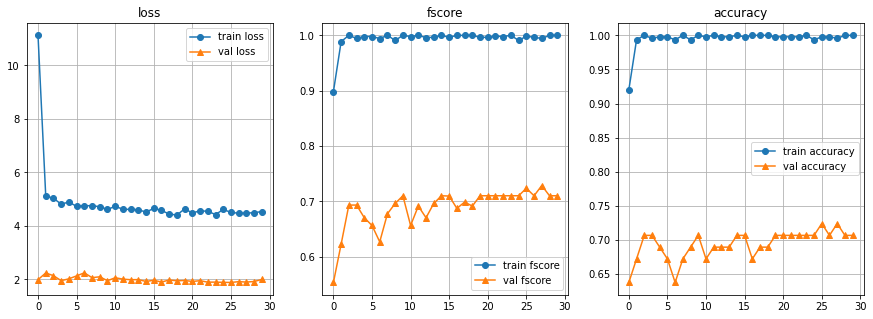

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(train_losses, '-o', label='train loss')
plt.plot(val_losses, '-^', label='val loss')
plt.title('loss')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_fscores, '-o', label='train fscore')
plt.plot(val_fscores, '-^', label='val fscore')
plt.title('fscore')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_accuracies, '-o', label='train accuracy')
plt.plot(val_accuracies, '-^', label='val accuracy')
plt.title('accuracy')
plt.legend()
plt.grid()

print(f'このモデルの正解率は{round(np.array(val_accuracies).max(),4)}です\n')
plt.show()



# 結果の確認

今回は学習データの上位10個が正常に予測できていることを確認します。

In [93]:

# 最初のデータの出力を確認する
test_data = TrainData(train_df,'test')

# DataLoaderを取得する
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

100%|██████████| 290/290 [00:35<00:00,  8.27it/s]


配列の最も大きいものが予測値となります。

In [94]:
preds = []
for batch in test_loader:
    input_ids = batch[0].to('cpu')
    net = net.to('cpu')
    out = net(input_ids)
    pred = out.argmax(dim=1)
    preds.append(pred.detach().numpy()[0])

category_idと予測値が同じになることを確認してください。

In [95]:
train_df['pred'] = preds
train_df['正解'] = [1 if train_df['category_id'][i] == train_df['pred'][i] else 0 for i in range(len(train_df))]

In [96]:
train_df

,path,category,category_id,pred,正解
0,./1_bridge/bridge_016.jpeg,1_bridge,1,1,1
1,./1_bridge/bridge_026.jpeg,1_bridge,1,1,1
2,./1_bridge/bridge_001.jpeg,1_bridge,1,1,1
3,./1_bridge/bridge_008.jpeg,1_bridge,1,1,1
4,./1_bridge/bridge_027.jpeg,1_bridge,1,1,1
...,...,...,...,...,...
285,./0_regular/regular_088.jpeg,0_regular,0,0,1
286,./0_regular/regular_024.jpeg,0_regular,0,0,1
287,./0_regular/regular_052.jpeg,0_regular,0,0,1
288,./0_regular/regular_078.jpeg,0_regular,0,0,1


# 画像ラベルとラベルIDの関係の確認

学習ずみモデルは「category_id」の数字の値を出力します。
「category」が写真のフォルダ名になりますので、idの値を記録しておいてください。

In [97]:
# 画像のラベルとラベルIDの関係を確認します。

train_df[['category','category_id']].groupby('category').mean()

,category_id
category,
0_regular,0
1_bridge,1
2_horn,2
3_potato,3


# 学習したモデルのダウンロード

In [98]:
from google.colab import files
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>